In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset

class MyDataset(Dataset):
  def __init__(self, size=5000, dim=40, random_offset=0):
        super(MyDataset, self).__init__()
        self.size = size
        self.dim = dim
        self.random_offset = random_offset

  def __getitem__(self, index):
      if index >= len(self):
          raise IndexError("{} index out of range".format(self.__class__.__name__))

      rng_state = torch.get_rng_state()
      torch.manual_seed(index + self.random_offset)

      while True:
        img = torch.zeros(self.dim, self.dim)
        dx = torch.randint(-10,10,(1,),dtype=torch.float)
        dy = torch.randint(-10,10,(1,),dtype=torch.float)
        c = torch.randint(-20,20,(1,), dtype=torch.float)

        params = torch.cat((dy/dx, c))
        xy = torch.randint(0,img.shape[1], (20, 2), dtype=torch.float)
        xy[:,1] = xy[:,0] * params[0] + params[1]

        xy.round_()
        xy = xy[ xy[:,1] > 0 ]
        xy = xy[ xy[:,1] < self.dim ]
        xy = xy[ xy[:,0] < self.dim ]

        for i in range(xy.shape[0]):
          x, y = xy[i][0], self.dim - xy[i][1]
          img[int(y), int(x)]=1
        if img.sum() > 2:
          break

      torch.set_rng_state(rng_state)
      return img.unsqueeze(0), params

  def __len__(self):
      return self.size
    
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    

train_data = MyDataset()
val_data = MyDataset(size=500, random_offset=33333)
test_data = MyDataset(size=500, random_offset=99999)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn
from torch.utils.data import DataLoader

seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
trainloader = DataLoader(train_data,batch_size= 128, shuffle=True)
testloader = DataLoader(test_data,batch_size= 128, shuffle=True)


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1,48,(3,3),stride=1,padding=1) # out 48 * 40*40
        self.fc1 = nn.Linear(48* 40*40,128)
        self.fc2 = nn.Linear(128 ,2)
        
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = out.view(out.shape[0],-1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out      

In [ ]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2,self).__init__()
        self.conv1 = nn.Conv2d(1,48,(3,3),stride=1,padding=1) # out 48 * 40*40
        self.conv2 = nn.Conv2d(48,48,(3,3),stride=1,padding=1) # out 48 * 40*40
        self.fc1 = nn.Linear(48,128)
        self.fc2 = nn.Linear(128 ,2)
        
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        pooling = nn.AdaptiveMaxPool2d((1,1))
        out = pooling(out)
        out = out.view(out.shape[0],-1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out 

In [ ]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3,self).__init__()
        self.conv1 = nn.Conv2d(3,48,(3,3),stride=1,padding=1) # out 48 * 40*40
        self.conv2 = nn.Conv2d(48,48,(3,3),stride=1,padding=1) # out 48 * 40*40
        self.fc1 = nn.Linear(48,128)
        self.fc2 = nn.Linear(128 ,2)
        
    def forward(self, x):
        idxx = torch.repeat_interleave(torch.arange(-20,20,dtype=torch.float).unsqueeze(0)/40.0,repeats=40,dim=0).to(device)
        idxy = idxx.clone().t()
        idx = torch.stack([idxx,idxy]).unsqueeze(0)
        idx = torch.repeat_interleave(idx,repeats=x.shape[0],dim=0)
        x = torch.cat([x,idx],dim=1)
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        pooling = nn.AdaptiveMaxPool2d((1,1))
        out = pooling(out)
        out = out.view(out.shape[0],-1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out 

In [ ]:
loss_func = F.mse_loss
# model = CNN().to(device)
# model = CNN2().to(device) 
model = CNN3().to(device)

adam_opt = torch.optim.Adam(params=model.parameters())
epochs = 100

loss_list1 = []
loss_list2 = []

for epoch in range(epochs):
    # training 
    loss_sum = 0
    for batch in trainloader:
        data,targets = batch
        adam_opt.zero_grad()
        out = model.forward(data.to(device))
        loss = loss_func(out.to(device),targets.to(device)).to(device)
        loss.backward()
        loss_sum += loss
        adam_opt.step()
    print("Epoch:{}, loss={}".format(epoch,loss_sum))
    
    # training loss
    training_loss = 0
    for batch in trainloader:
        data,targets = batch
        out = model.forward(data.to(device))
        loss = loss_func(out.to(device),targets.to(device)).to(device)
        training_loss += loss
    #test
    test_loss = 0
    for batch in testloader:
        data,targets = batch
        out = model.forward(data.to(device))
        loss = loss_func(out.to(device),targets.to(device)).to(device)
        test_loss += loss
    print("Training loss:{}, test loss: {}".format(training_loss/len(trainloader),test_loss/len(testloader)))
    loss_list1.append(training_loss.item()/len(trainloader))
    loss_list2.append(test_loss.item()/len(testloader))

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')
torch.Size([1, 40, 40])
tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
         [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
         [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
         ...,
         [-0.5000, -0.4750, 

KeyboardInterrupt: ignored

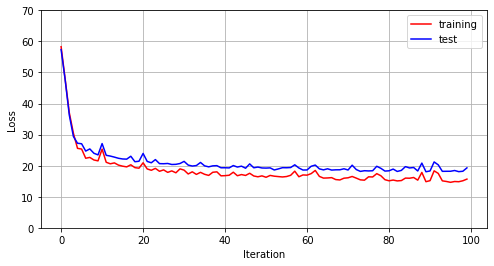

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (8,4))
ax.plot(loss_list1, color = "red",label="training")
ax.plot(loss_list2, color = "blue",label="test")
ax.grid(True)
plt.ylabel("Loss")
plt.xlabel("Iteration")
ax.set_ylim(0,70)
ax.legend()
plt.savefig("loss.png")

# 新段落

# 新段落